## Preâmbulo


In [404]:
import numpy as np
import pandas as pd
import exp_physics as ep
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as scp

sns.set_style('darkgrid')

In [405]:
# Dados da luz azul variando intensidade

A20 = pd.read_csv('dados/A20.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A40 = pd.read_csv('dados/A40.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A60 = pd.read_csv('dados/A60.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A80 = pd.read_csv('dados/A80.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A100 = pd.read_csv('dados/A100.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})

Amarelo = pd.read_csv('dados/Amarelo.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Verde = pd.read_csv('dados/Verde.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Ultra = pd.read_csv('dados/Ultra.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Violeta = pd.read_csv('dados/Violeta.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Azul = pd.read_csv('dados/Azul.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Preto = pd.read_csv('dados/Preto.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Fundo = pd.read_csv('dados/Fundo.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})

In [406]:
l_Intensidade = [A20, A40, A60, A80, A100]

l_Cores = [Preto, Fundo, Amarelo, Verde, Azul, Violeta, Ultra]

In [407]:
def calc_sigma_i(i):
    if i < 10*10e-9:
        return i*(0.3/100) + 400 * 10e-14
    if i < 100*10e-9:
        return i*(0.2/100) + 1 * 10e-12
    else:
        return i*(0.15/100) + 10 * 10e-12

def calc_sigma_V(V):
    return V*(0.1/100) + 1 * 10e-3

In [408]:
for df in l_Intensidade:
    df['si'] = df['i'].apply(calc_sigma_i)
    df['sV'] = df['V'].apply(calc_sigma_V)

for df in l_Cores:
    df['si'] = df['i'].apply(calc_sigma_i)
    df['sV'] = df['V'].apply(calc_sigma_V)

In [409]:
l_Cores = [Amarelo, Verde, Azul, Violeta, Ultra]

nomes = ['Amarelo', 'Verde', 'Azul', 'Violeta', 'Ultravioleta']

paleta = ['gold', 'seagreen', 'royalblue', 'darkorchid', 'indigo']

In [410]:
def propaga_si(si1,si2):
    return np.sqrt(si1**2 + si2**2)

## Correção da corrente

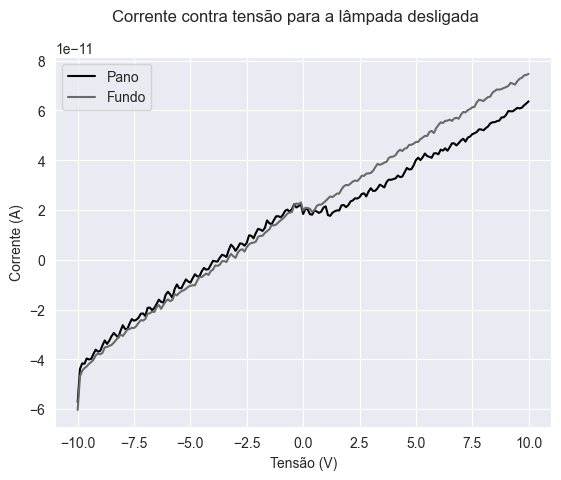

In [411]:
sns.lineplot(x=Preto['V'], y=Preto['i'], label = 'Pano', c ='black')
sns.lineplot(x=Fundo['V'], y=Fundo['i'], label = 'Fundo', c = 'dimgray')

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para a lâmpada desligada')


plt.savefig('plots/fundo.png')


plt.show()

Para corrigir a corrente, primeiro vamos remover o ruído da corrente de fundo sem o pano, subtraindo a corrente de fundo da corrente. Em seguida, vamos propagar as incertezas.

$$i^\prime = i - i_{fundo}$$

Podemos propagar por meio de:

$$\sigma_{i^\prime} = \sqrt{\sigma_i^2 + \sigma_{i_{fundo}}^2} $$

In [412]:
for df in l_Intensidade:
    df['i'] = df['i'] - Fundo['i']
    df['si'] = propaga_si(df['si'], Fundo['si'])

for df in l_Cores:
    df['i'] = df['i'] - Fundo['i']
    df['si'] = propaga_si(df['si'], Fundo['si'])

Agora vamos encontrar o valor da corrente do ânodo e subtrair, da mesma forma:

$$i_c = i^\prime - i_a$$
Faremos uma aproximação usando a região onde $i_c<0$, que deveria ser $i_c = 0$. Então, assumimos que:

$$i^\prime = i_c + i_a$$

$$\therefore i^\prime = i_a \text{, na região onde } i^\prime < 0$$
Vamos analisar as funções nesse intervalo:

Text(0.5, 1.0, 'Corrente por tensão quando $i<0$')

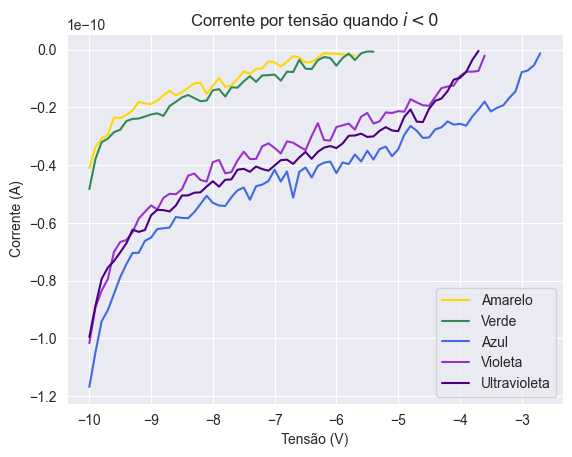

In [413]:
for i, cor in enumerate(l_Cores):
    sns.lineplot(x=cor['V'], y=cor[cor['i']<0]['i'], color=paleta[i], label=nomes[i])

plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title(r'Corrente por tensão quando $i<0$')

Como o intervalo é pequeno, podemos fazer uma aproximação linear:

$$i(V) = A\cdot V + B$$

Ou, podemos considerar o formato da curva e usar uma função exponencial, tirando logaritmo para torná-la linear:

$$i_a(V) = -B\cdot e^{-A\cdot V}$$

$$|i_a(V)| = B\cdot e^{-A\cdot V}$$

$$\log(|i_a|) = \log(B) - A\cdot V$$

Vamos testar os dois métodos.

In [414]:
lfunc = lambda x, A, B: A*x + B

logfunc = lambda x, A, B: B - A*x

In [415]:
fit_linear = []
cov_linear = []

fit_log = []
cov_log = []

for cor in l_Cores:
    fit1, cov1 = scp.curve_fit(lfunc, cor[cor['i']<0]['V'], cor[cor['i']<0]['i'], sigma=cor[cor['i']<0]['si'], absolute_sigma=True)
    fit2, cov2 = scp.curve_fit(logfunc, cor[cor['i']<0]['V'], np.log(abs(cor[cor['i']<0]['i'])), sigma=cor[cor['i']<0]['si'], absolute_sigma=True)

    fit_linear.append(fit1)
    cov_linear.append(cov1)

    fit_log.append(fit2)
    cov_log.append(cov2)

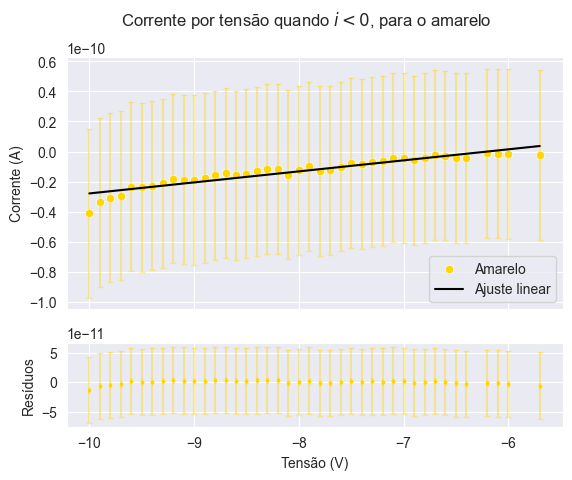

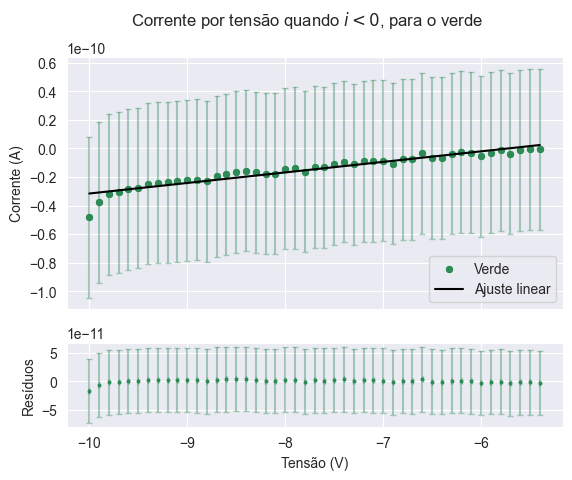

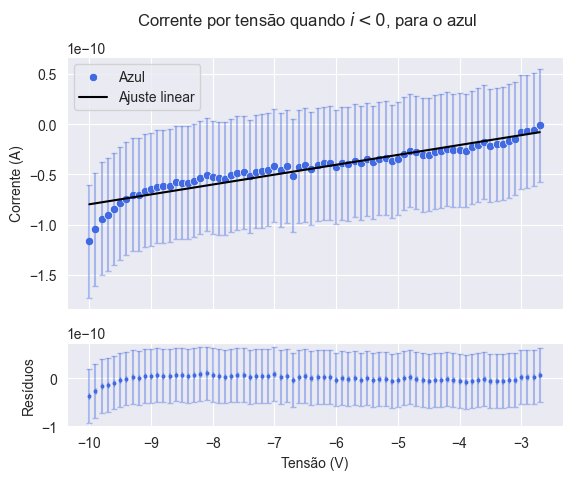

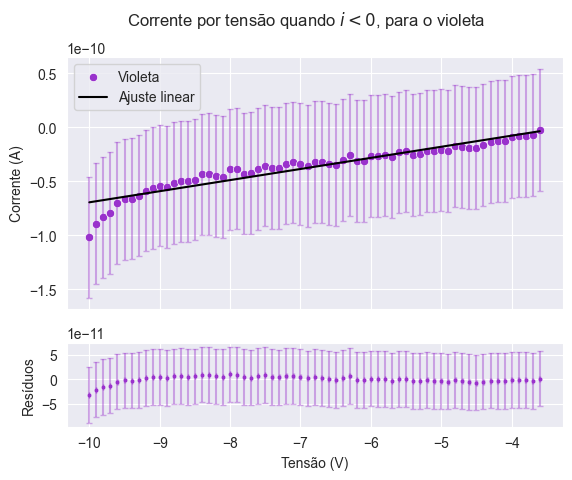

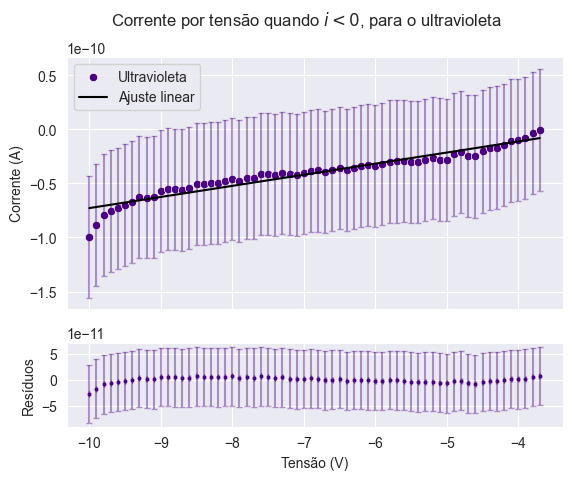

In [416]:
for df, fit, cor, nome in zip(l_Cores, fit_linear, paleta, nomes):

   fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

   x = df[df['i']<0]['V']
   y = df[df['i']<0]['i']
   x_sigma = df[df['i']<0]['sV']
   y_sigma = df[df['i']<0]['si']

   alpha = 0.4
   
   # Gráfico dos dados
    
   sns.scatterplot(x=x,
                    y=y,
                    color=cor,
                    label=nome,
                    ax=ax1)
   
   # Resíduos
   
   y_res = y - lfunc(x, *fit)
   sns.scatterplot(x=x, y=y_res, ax=ax2,color=cor, s=10)

   # Incertezas

   ax1.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, fmt=' ', capsize=2,c=cor, alpha=alpha)
   ax2.errorbar(x, y_res, xerr=x_sigma, yerr=y_sigma, fmt=' ', capsize=2,c=cor, alpha=alpha)

   # Ajuste linear

   sns.lineplot(x= x, 
                y= lfunc(x, *fit),
                color='black',
                label = 'Ajuste linear',
                ax=ax1)

   # Nomes de eixos e título
   
   plt.xlabel('Tensão (V)')
   ax1.set_ylabel('Corrente (A)')
   ax2.set_ylabel('Resíduos')
   plt.suptitle(f'Corrente por tensão quando $i<0$, para o {nome.lower()}')


   plt.savefig(f'plots/ajustes_linear/{nome}_linear.png')

   plt.show()

Agora, vamos subtrair os valores de $i_a$ de $i^\prime$ e propagar as incertezas.

Text(0.5, 1.0, 'Corrente por tensão quando $i<0$')

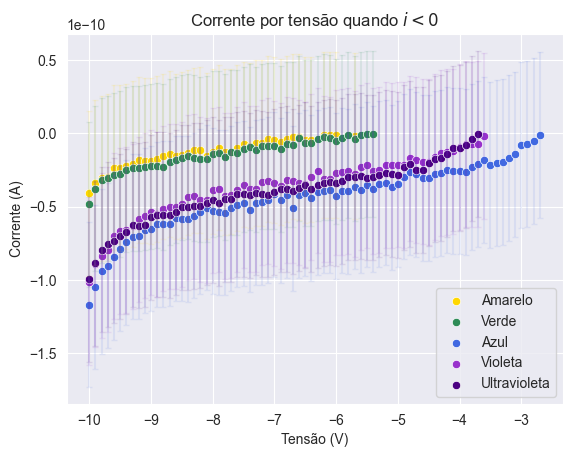

In [417]:
for df, cor, nome in zip(l_Cores, paleta, nomes):

    x = df[df['i']<0]['V']
    y = df[df['i']<0]['i']

    x_sigma = df[df['i']<0]['sV']
    y_sigma = df[df['i']<0]['si']

    alpha = 0.1

    sns.scatterplot(x=x, y=y, color=cor, label=nome)

    plt.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, fmt=' ', capsize=2,c=cor, alpha=alpha)
    

plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title(r'Corrente por tensão quando $i<0$')

In [418]:
for cor, fit in zip(l_Cores, fit_linear):
    cor.loc[cor['i']<0, 'i'] = cor[cor['i']<0]['i'] - lfunc(cor[cor['i']<0]['V'], *fit)

Text(0.5, 1.0, 'Corrente por tensão quando $i<0$, após a correção')

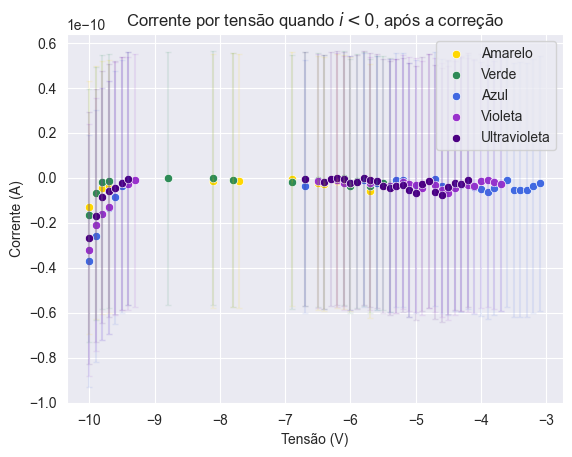

In [419]:
for df, cor, nome in zip(l_Cores, paleta, nomes):

    x = df[df['i']<0]['V']
    y = df[df['i']<0]['i']

    x_sigma = df[df['i']<0]['sV']
    y_sigma = df[df['i']<0]['si']

    alpha = 0.1

    sns.scatterplot(x=x, y=y, color=cor, label=nome)

    plt.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, fmt=' ', capsize=2,c=cor, alpha=alpha)
    

plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title(r'Corrente por tensão quando $i<0$, após a correção')

In [420]:
for df, nome in zip(l_Cores,nomes):
    df.to_csv(f'dados/corrigidos/linear/{nome}_corrigido_linear.csv')

## Determinação do $V_0$

In [421]:
lambdas = np.array([(5789.69+5769.60)/2, 5460.74, 4358.35, 4046.56, 3654.83])

lambdas = lambdas*10e-10

c = 29959e8

freqs = c/lambdas

ec = 1.6022e-19

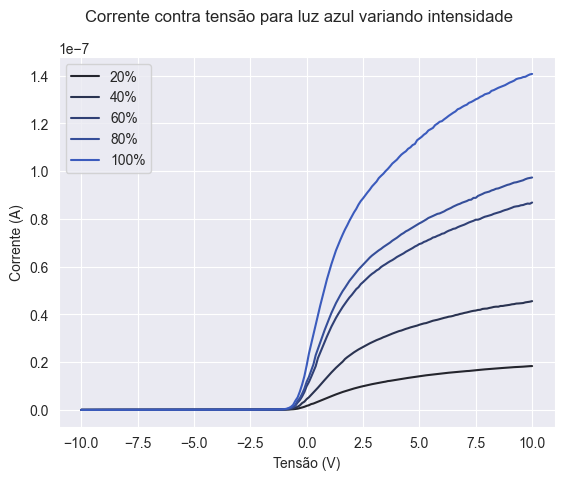

In [422]:
sns.set_palette(sns.dark_palette('royalblue'))
sns.lineplot(x=A20['V'], y=A20['i'],label = '20%')
sns.lineplot(x=A40['V'], y=A40['i'], label = '40%' )
sns.lineplot(x=A60['V'], y=A60['i'], label = '60%')
sns.lineplot(x=A80['V'], y=A80['i'], label = '80%')
sns.lineplot(x=A100['V'], y=A100['i'], label = '100%')

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para luz azul variando intensidade')


plt.savefig('plots/azul_intensidade.png')
plt.show()



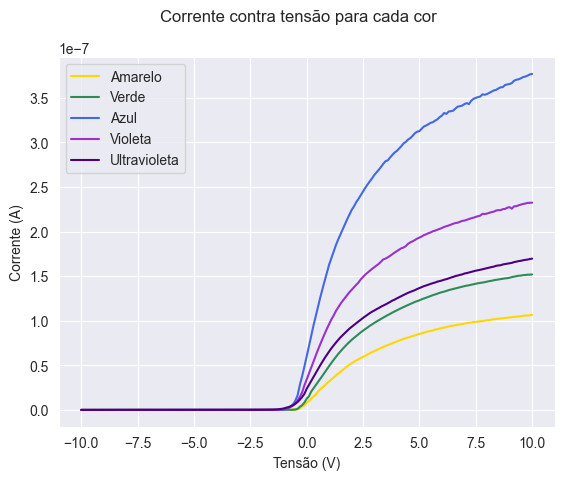

In [423]:
for df, cor, nome in zip(l_Cores, paleta, nomes):
    sns.lineplot(x=df['V'], y=df['i'], color=cor, label=nome)

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para cada cor')


plt.savefig('plots/cores.png')
plt.show()

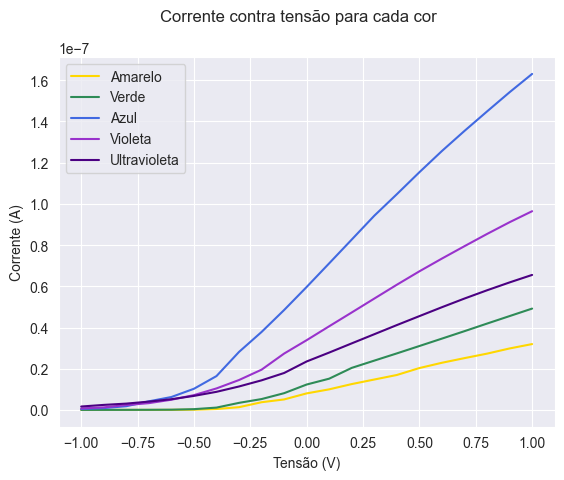

In [424]:
for df, cor, nome in zip(l_Cores, paleta, nomes):

    delta = 1

    x = df[(df['V'] >= -delta) & (df['V'] <= 1)]['V']
    y = df[(df['V'] >= -delta) & (df['V'] <= 1)]['i']

    sns.lineplot(x=x, y=y, color=cor, label=nome)

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para cada cor')


plt.savefig('plots/cores_zoom.png')
plt.show()

In [439]:
cores_superior = []

cores_inferior = []

for df in l_Cores:
    cores_superior.append(df[(df['V'] >= 0.25) & (df['V'] <= .75)])
    cores_inferior.append(df[(df['V'] <= -0.75)])

In [440]:
fit_superior = []
fit_inferior= []

cov_superior = []
cov_inferior = []

for df1, df2 in zip(cores_superior, cores_inferior):
    fit1, cov1 = scp.curve_fit(lfunc, df1['V'], df1['i'], sigma=df1['si'], absolute_sigma=True)
    fit2, cov2 = scp.curve_fit(lfunc, df2['V'], df2['i'], sigma=df2['si'], absolute_sigma=True)

    fit_superior.append(fit1)
    fit_inferior.append(fit2)

    cov_superior.append(cov1)
    cov_inferior.append(cov2)

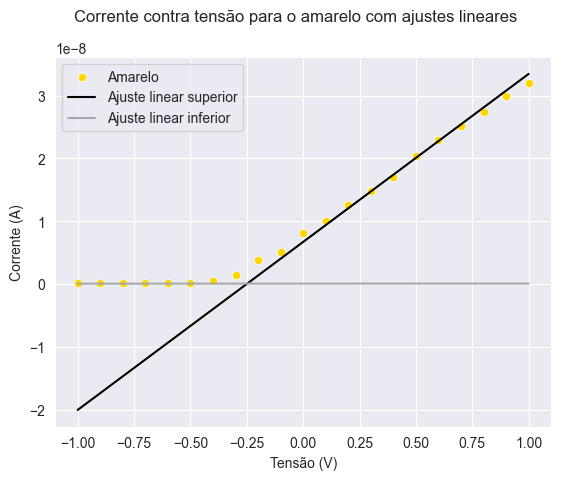

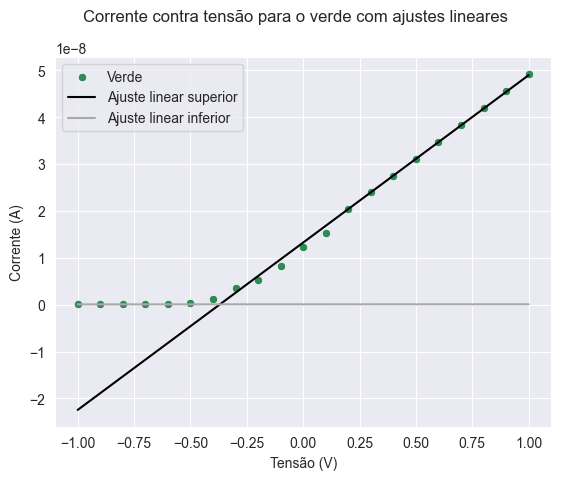

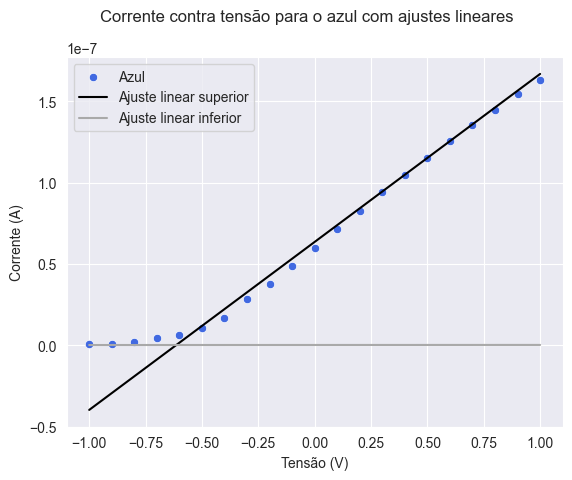

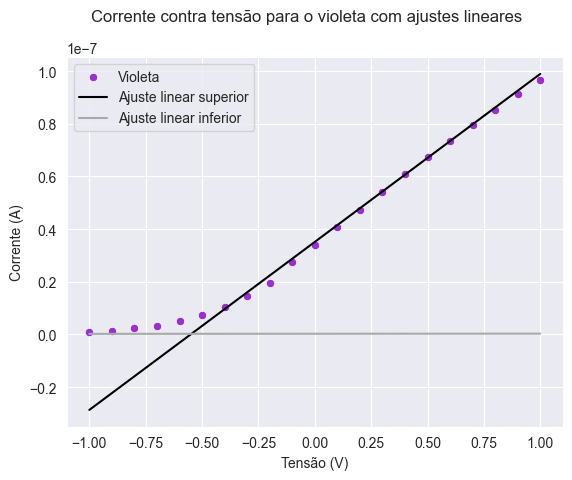

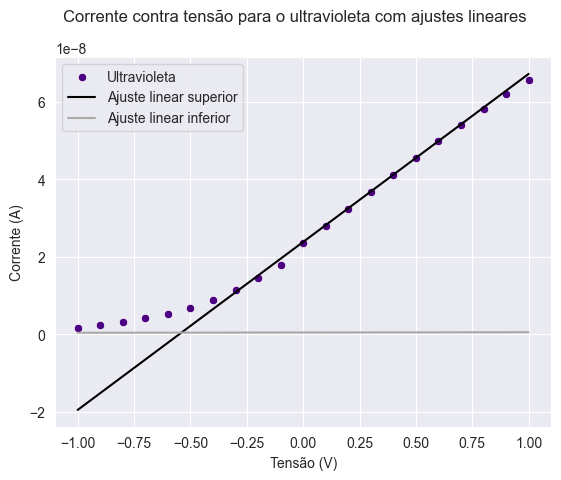

In [441]:
for df, cor, nome, fit1, fit2 in zip(l_Cores, paleta, nomes, fit_superior, fit_inferior):

    delta = 1

    x = df[(df['V'] >= -delta) & (df['V'] <= 1)]['V']
    y = df[(df['V'] >= -delta) & (df['V'] <= 1)]['i']

    sns.scatterplot(x=x, y=y, color=cor, label=nome)

    sns.lineplot(x=x, y=lfunc(x, *fit1), color='black', label='Ajuste linear superior')
    sns.lineplot(x=x, y=lfunc(x, *fit2), color='darkgrey', label='Ajuste linear inferior')

    plt.xlabel("Tensão (V)")
    plt.ylabel('Corrente (A)')

    plt.suptitle(f'Corrente contra tensão para o {nome.lower()} com ajustes lineares')


    #plt.savefig('plots/cores_zoom.png')
    plt.show()

In [442]:
l_V01 = []
l_V02 = []

for fit1, fit2 in zip(fit_superior, fit_inferior):

    V01 = lfunc(0, *fit1)
    V02 = lfunc(0, *fit2)

    l_V01.append(V01)
    l_V02.append(V02)


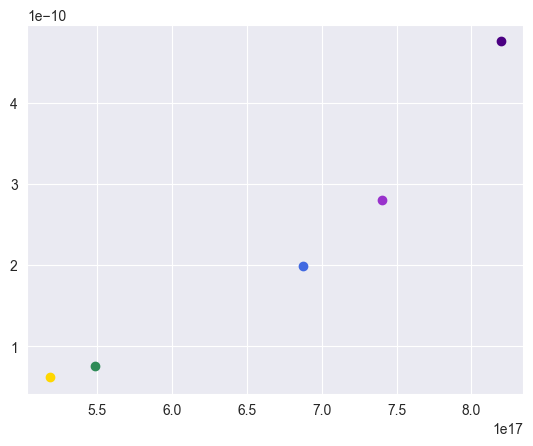

In [443]:
fitV01, covV01 = scp.curve_fit(lfunc, freqs, l_V01)
fitV02, covV02 = scp.curve_fit(lfunc, freqs, l_V02)

for V01, V02, freq, cor, nome in zip(l_V01, l_V02, freqs, paleta, nomes):
    plt.scatter(freq, V01, color=cor, label=f'nome')
    plt.scatter(freq, V02, color=cor, label=f'nome')

# ARRUMAR DEPOIS

In [444]:
'''
for df, fit, cor, nome in zip(l_Cores, fit_log, paleta, nomes):

   fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

   x = df[df['i']<0]['V']
   y = df[df['i']<0]['i']
   x_sigma = df[df['i']<0]['sV']
   y_sigma = df[df['i']<0]['si']

   # Ajuste linear (logarítmico)

   sns.lineplot(x= x, 
                y= logfunc(x, fit[0], fit[1]),
                color='black',
                label = 'Ajuste linear',
                ax=ax1)
    
   # Gráfico dos dados (logarítmico)

   sns.scatterplot(x=x,
                    y=np.log(abs(y)),
                    color=cor,
                    label=nome,
                    ax=ax1)
   
      # Resíduos
   
   y_res = np.log(abs(y)) - logfunc(x, *fit)
   sns.scatterplot(x=x, y=y_res, ax=ax2,color=cor, s=10)

   # Incertezas

   #ax1.errorbar(x, y, xerr=x_sigma, yerr=np.log(y_sigma), fmt=' ', capsize=2,c=cor, alpha=0.2)
   #ax2.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, fmt=' ', capsize=2,c=cor, alpha=0.2)

   # Nomes de eixos e título
   
   plt.xlabel('Tensão (V)')
   ax1.set_ylabel(r'log($|Corrente|$) (log(A))')
   ax2.set_ylabel('Resíduos')
   plt.suptitle(f'Logaritmo do módulo da corrente por tensão quando $i<0$, para o{nome}')


   plt.savefig(f'plots/ajustes_log/{nome}_log.png')

   plt.show()
'''

"\nfor df, fit, cor, nome in zip(l_Cores, fit_log, paleta, nomes):\n\n   fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})\n\n   x = df[df['i']<0]['V']\n   y = df[df['i']<0]['i']\n   x_sigma = df[df['i']<0]['sV']\n   y_sigma = df[df['i']<0]['si']\n\n   # Ajuste linear (logarítmico)\n\n   sns.lineplot(x= x, \n                y= logfunc(x, fit[0], fit[1]),\n                color='black',\n                label = 'Ajuste linear',\n                ax=ax1)\n    \n   # Gráfico dos dados (logarítmico)\n\n   sns.scatterplot(x=x,\n                    y=np.log(abs(y)),\n                    color=cor,\n                    label=nome,\n                    ax=ax1)\n   \n      # Resíduos\n   \n   y_res = np.log(abs(y)) - logfunc(x, *fit)\n   sns.scatterplot(x=x, y=y_res, ax=ax2,color=cor, s=10)\n\n   # Incertezas\n\n   #ax1.errorbar(x, y, xerr=x_sigma, yerr=np.log(y_sigma), fmt=' ', capsize=2,c=cor, alpha=0.2)\n   #ax2.errorbar(x, y, xerr=x_sigma, yerr=y_sigma,